# Clustering: k-means and GMM

-----------------------------------------

## Project Guide
- [Building Cluster Assignment Algorithms](#Building-Cluster-Assignment-Algorithms)
- [Building Cluster Update Functions](#Building-Cluster-Update-Functions)
- [Clustering in sklearn](#Clustering-in-sklearn)

## Project Overview

------------------------

#### EXPECTED TIME 2.5 HRS

In general, the steps of a clustering algorithms are straightforward: the sample points are assigned to centroids and the centroids coordinate get updated. These two main steps repeat until we get convergence in our algorithm.  

When using clustering, some of the difficult steps consist in choosing how many centroids are needed and how these centroids should be initialized. Although these are important topics in clustering, in this assignment we will focus on the main steps that define the clustering algorithm.  

In particular, you will be asked to write functions that compute k-means, soft k-means, and GMM clustering. Your functions will perform these following two main steps:

- Assign points to clusters.
- Recalculating and update the clusters and their centroids.

**Data:** For this exercise, we will use derived data in two dimensions. Three clusters of data were derived from three different distributions in four different instances.

See the below visualization for the four different sets of distributions.  

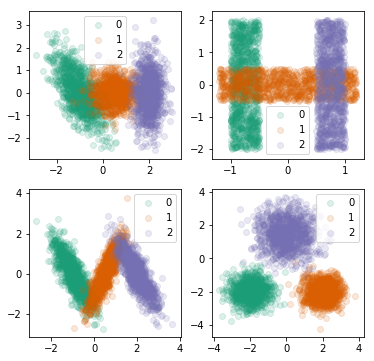

In [2]:
from scipy.stats import multivariate_normal
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# File Paths
mv_path = "../resource/asnlib/publicdata/mv.csv"
unif_path = "../resource/asnlib/publicdata/unif.csv"
mv2_path = "../resource/asnlib/publicdata/mv2.csv"
mv3_path = "../resource/asnlib/publicdata/mv3.csv"

# Read in Data
mv_df = pd.read_csv(mv_path, index_col = 0)
unif_df = pd.read_csv(unif_path, index_col = 0)
mv2_df = pd.read_csv(mv2_path, index_col = 0)
mv3_df = pd.read_csv(mv3_path, index_col = 0)

# Create Figure
fig, (axs) = plt.subplots(2,2, figsize = (6,6))

# Plot each group in each dataset as unique olor
for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
    for cat, col in zip(df['cat'].unique(), ["#1b9e77", "#d95f02", "#7570b3"]):
        ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, c = col, label = cat, alpha = .15)
    ax.legend()

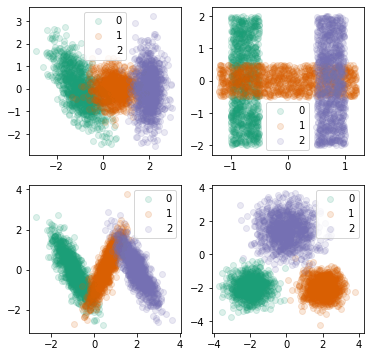

In [1]:
# from scipy.stats import multivariate_normal
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# %matplotlib inline

# # File Paths
# mv_path = "mv.csv"
# unif_path = "unif.csv"
# mv2_path = "mv2.csv"
# mv3_path = "mv3.csv"

# # Read in Data
# mv_df = pd.read_csv(mv_path, index_col = 0)
# unif_df = pd.read_csv(unif_path, index_col = 0)
# mv2_df = pd.read_csv(mv2_path, index_col = 0)
# mv3_df = pd.read_csv(mv3_path, index_col = 0)

# # Create Figure
# fig, (axs) = plt.subplots(2,2, figsize = (6,6))

# # Plot each group in each dataset as unique olor
# for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
#     for cat, col in zip(df['cat'].unique(), ["#1b9e77", "#d95f02", "#7570b3"]):
#         ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, c = col, label = cat, alpha = .15)
#     ax.legend()

Throughout this assignment, we will assign to each centroid a pair of coordinates $(x,y)$. 

In the case of GMM models, the center of each cluster will be initialized by a $2x2$ covariance matrix  

 $$\Sigma = \begin{bmatrix}
    1 & 0\\
    0&1
\end{bmatrix},$$ 

and by $\pi = \frac1k$,  with $k$ being the number of clusters.


We will initialize the clusters by using a K-means++ type algorithm.

The K-means++ algorithm chooses one point from the data as the first cluster center. The next cluster centers are chosen from the remaining points. The probability of picking any other point is proportional to the square of the euclidean distance of that point to the nearest cluster center. 

In [2]:
# Implement K-means ++ to initialize centers

def pick_cluster_centers(points, num_clusters = 3):
    # Create List to store clusters
    clusters = []
    
    # Save list of cluster indicies
    arr_idx = np.arange(len(points))
    
    # Choose first cluster; append to list
    clusters.append( points[np.random.choice(arr_idx)])
    
    # Define function to calculate squared distance
    def dist_sq(x): return np.linalg.norm(x)**2
    
    c_dist = None

    # Add Clusters until reaching "num_clusters"
    while len(clusters) < num_clusters:
        
        # Calculate distance between latest cluster and rest of points
        new_dist = np.apply_along_axis(np.linalg.norm, 1, points - clusters[-1]).reshape(-1,1)
        
        # Add to distance array - First check to see if distance matrix exists
        if type(c_dist) == type(None):
            c_dist = new_dist
            
        else:
            c_dist = np.concatenate([c_dist, new_dist], axis = 1)
        
        # Calculate probability by finding shortest distance, then normalizing
        c_prob = np.apply_along_axis(np.min, 1, c_dist)
        c_prob = c_prob / c_prob.sum()

        # Draw new cluster according to probability
        clusters.append(points[np.random.choice(arr_idx, p = c_prob)])
            
    return np.array(clusters)

# Function to add pi and Sigma for GMM clusters
def build_GMM_clusters(clusters):
    return [(c, 1/len(clusters), np.array([[1,0],[0,1]])) for c in clusters]

#### Method of Describing Cluster Assignments
In hard clustering, i.e., k-means, each point is assigned exclusively to one cluster. In soft clustering, i.e., soft k-means and GMM, points may be portioned out between clusters.  

For this reason, throughout this assignment, the allocation of the points to the clusters will be stored in a two-dimensional `numpy` array. 

For example, assume that we are working with three clusters and one point.
In k-means clustering, if a single point was assigned to cluster "0", its cluster assignment would be `[1,0,0]`. On the other hand, if we were working using soft k-means clustering, if the point was evenly split between the three clusters, its cluster assignment would be `[.33,.33,.33]`.  

In the case that we have three points and two clusters, when using k-means, the cluster-matrix would be: `np.array([[1,0],[1,0],[0,1]])`. In this case, the first two points are assigned to cluster "0" and the third point is assigned to cluster "1".  

Note: the `np.apply_along_axis` attribute will be useful in the following exercises.  

### Building Cluster Assignment Algorithms

#### Question 1

For each point $i$, the cluster indicator $c_i$ for the cluster $k$ can be computed according to the equation

$$c_i =\text{argmin}_k\ ||x_i - \mu_k||^2.$$

Write a function called `assign_clusters_k_means` that accepts the following 
arguments:

- A two-dimensional `numpy` array with the coordinates of each point.
- A two-dimensional `numpy` array with the coordinates of the centroid of each cluster.

Your function should determine which cluster centroid is closest to each point and return a two-dimensional `numpy` array where each row indicates to which cluster a point is closets to. For example, the row [0,1,0,...,0] would indicates that the point is assigned to the second cluster, and the row [0,0,...,1] indicates the point is assigned to the last cluster.

In [12]:
### GRADED

### Assign points to clusters according to the k-means algorithm
### Follow directions above

### YOUR ANSWER BELOW

def assign_clusters_k_means(points, clusters):
    """
    Determine the nearest cluster to each point, returning an array indicating the closest cluster
    
    Positional Arguments:
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        clusters: a 2-d numpy array where each row is a different centroid cluster;
            each column indicates the location of that centroid in that dimension
    
    Example:
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        clusters = np.array([[0,1],[5,4]])
        cluster_weights = assign_clusters_k_means(points, clusters)
        
        print(cluster_weights) #--> np.array([[1, 0],
                                              [1, 0],
                                              [0, 1],
                                              [0, 1],
                                              [0, 1]])
    """
    # NB: "cluster_weights" is used as a common term between functions
    # the name makes more sense in soft-clustering contexts
    
    N,D = np.shape(points)
    C,K = np.shape(clusters)
    cluster_weights = np.zeros((N,C),dtype = int)
    for index,point in enumerate(points):
        val = np.argmin(np.sum(np.square(clusters-point),axis=1))
        #print(cluster_weights,val)
        cluster_weights[index][val] = 1
    return cluster_weights

In [13]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
clusters = np.array([[0,1],[5,4],[2,3]])
cluster_weights = assign_clusters_k_means(points, clusters)

print(cluster_weights) #--> np.array([[1, 0],[1, 0],[0, 1],[0, 1],[0, 1]])

[[1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [8]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 2
Define a  function called `assign_clusters_soft_k_means` that accepts the following 
arguments:

- A two-dimensional `numpy` array with the coordinates of each point.
- A two-dimensional `numpy` array with the coordinates of the centroid of each cluster.
- beta: a number that defines what distance between points and clusters we consider to be small enough.

Your function should return a two-dimensional `numpy` array with the cluster weights. Each row in the array should indicate the proportion of how each point "belongs" to all the clusters. For example, if a point "belongs" evenly to two clusters, the corresponding row in the array should be: [.5,.5].  


The proportion $\phi_i(k)$ that a point $i$ belongs to a cluster $k$ is defined by the function for weighted k-means: 

$$\phi_i(k) = \frac{\exp\{-\frac{1}{\beta}||x_i-\mu_k||^2\}}{\sum_j \exp\{-\frac1\beta||x_i-\mu_j||^2\}}$$  


In [98]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def assign_clusters_soft_k_means(points, clusters, beta):
    
    """
    Return an array indicating the proportion of the point
        belonging to each cluster
    
    Positional Arguments:
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        clusters: a 2-d numpy array where each row is a different centroid cluster;
            each column indicates the location of that centroid in that dimension
        beta: a number indicating what distance can be considered "close"
        
    Example:
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        clusters = np.array([[0,1],[5,4]])
        beta = 1
        cluster_weights = assign_clusters_soft_k_means(points, clusters, beta)
        
        print(cluster_weights) #--> np.array([[0.99707331, 0.00292669],
                                              [0.79729666, 0.20270334],
                                              [0.00292669, 0.99707331],
                                              [0.04731194, 0.95268806],
                                              [0.1315826 , 0.8684174 ]])
    """
    
    N, _ = points.shape
    K, D = clusters.shape
    cluster_weights = np.zeros((N, K))

    for n in range(N):        
        cluster_weights[n] = np.exp(-beta * np.linalg.norm(clusters - points[n], 2, axis=1)) 
    cluster_weights /= cluster_weights.sum(axis=1, keepdims=True)
    
    return cluster_weights

In [99]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
clusters = np.array([[0,1],[5,4]])
beta = 1
cluster_weights = assign_clusters_soft_k_means(points, clusters, beta)

print(cluster_weights)

[[0.99707331 0.00292669]
 [0.79729666 0.20270334]
 [0.00292669 0.99707331]
 [0.04731194 0.95268806]
 [0.1315826  0.8684174 ]]


In [29]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 3
Define a  function called `assign_clusters_GMM` that accepts the following 
arguments:

- A two-dimensional `numpy` array with the coordinates of each point.
- A list of tuples. The $k^{th}$ tuple in the list should contain the parameters $(\mu_k, \pi_k, \Sigma_k)$ defining the cluster k. In particular, $\mu$ is a one-dimensional `numpy` array, $\pi$ is number, and $\Sigma$ is two-dimensional `numpy` array.

Your function should return a two-dimensional `numpy` array with the cluster weights. Each row in the array should indicate the proportion of how each point "belongs" to all the clusters. For example, if a point "belongs" evenly to two clusters, the corresponding row in the array should be: [.5,.5].    


For this question, the proportion $\phi_i(k)$ that a point $i$ belongs to cluster $k$ is defined by the $\phi$ function for GMM:  

$$\phi_i(k) = \frac{\pi_k N(x_i|\mu_k,\Sigma_k)}{\sum_j \pi_j N(x_i|\mu_j,\Sigma_k)},$$ 

where $N(x_i|\mu_k,\Sigma_k)$ can be computed by using `stats.multivariate_normal(mu,Sigma).pdf(x)`. For example, if $i = 0$ and $k = 0$, then  

    c = clusters[0]
    p = points[0]
    stats.multivariate_normal(c[0],c[2]).pdf(x)


In [42]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def assign_clusters_GMM(points, clusters):
    """    
    Return an array indicating the porportion of the point
        belonging to each cluster
    
    Positional Arguments:
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        clusters: a list of tuples. Each tuple describes a cluster.
            The first element of the tuple is a 1-d numpy array indicating the
                location of that centroid in each dimension
            The second element of the tuple is a number, indicating the weight (pi)
                of that cluster
            The thrid element is a 2-d numpy array corresponding to that cluster's
                covariance matrix.
        
    Example:
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        clusters = [(np.array([0,1]), 1, np.array([[1,0],[0,1]])),
                    (np.array([5,4]), 1, np.array([[1,0],[0,1]]))]
        
        cluster_weights = assign_clusters_GMM(points, clusters)
        
        print(cluster_weights) #--> np.array([[9.99999959e-01 4.13993755e-08]
                                              [9.82013790e-01 1.79862100e-02]
                                              [4.13993755e-08 9.99999959e-01]
                                              [2.26032430e-06 9.99997740e-01]
                                              [2.47262316e-03 9.97527377e-01]])
    """
    
    N,D = np.shape(points)
    K,J = np.shape(clusters)
    cluster_weights = np.zeros((N,K))
    for i,item in enumerate(points):
        res = 0
        for x in clusters:
            res+=x[1]*stats.multivariate_normal(x[0],x[2]).pdf(item)
        #print(item,res)
        for j,p in enumerate(clusters):
            cluster_weights[i][j] = p[1]*stats.multivariate_normal(p[0],p[2]).pdf(item)/res

    return cluster_weights

In [43]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
clusters = [(np.array([0,1]), 1, np.array([[1,0],[0,1]])),
            (np.array([5,4]), 1, np.array([[1,0],[0,1]]))]

cluster_weights = assign_clusters_GMM(points, clusters)

print(cluster_weights)

[[9.99999959e-01 4.13993755e-08]
 [9.82013790e-01 1.79862100e-02]
 [4.13993755e-08 9.99999959e-01]
 [2.26032430e-06 9.99997740e-01]
 [2.47262316e-03 9.97527377e-01]]


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Building Cluster Update Functions

#### Question 4

Define a  function called `update_clusters_k_means` that accepts the following 
arguments:

- A two-dimensional `numpy` array with the coordinates of each point.
- A two-dimensional `numpy` array indicating the cluster assignment to each point. We will define this array to be `cluster_weights`. Each row of `cluster_weights` should contain a single 1 and 0's everywhere else. For example, if the point $i$ is assigned to  cluster  "0", then the row corresponding to the point $i$ in `cluster_weights` should be [1,0,0,...,0].  

Your function should return a two-dimensional `numpy` array giving the new locations of the centroid for each cluster. 

For this question, the centroid $\mu_k$ for the cluster $k$ should be updated with the formula:  

$$\mu_k = \frac{\sum_ix_i\mathbb{1}\{c_i = k\}}{\sum_i\mathbb{1}\{c_i = k\}},$$

where $c_i$ indicates to which cluster point $i$ was assigned. Remember that, generally, the new centroids are the center (mean) of all points associated with the cluster.

 


In [40]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def update_clusters_k_means(points, cluster_weights):
    
    """
    Update the cluster centroids via the k-means algorithm
    
    Positional Arguments -- 
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        cluster_weights: a 2-d numy array where each row corresponds to each row in "points"
            and the columns indicate which cluster the point "belongs" to - a "1" in the kth
            column indicates belonging to the kth cluster
            
    Example:
    
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        cluster_weights = np.array([[1, 0],[1, 0],[0, 1],[0, 1],[0, 1]])
        
        new_cents = update_clusters_k_means(points, cluster_weights)
        
        print(new_cents) #--> np.array([[1. , 1.5],
                                        [4. , 4. ]])
    
    """
    N,D = np.shape(points)
    K,J = np.shape(cluster_weights)
    new_clusts = np.zeros((J,D))
    #print(new_clusts)
    c=np.zeros(len(points),dtype=int)
    for i,point in enumerate(cluster_weights):
        c[i] = np.where(point==1)[0][0]
    ind = np.array(list(set(c)))
    #print(ind)
    for k in range(len(ind)):
        #print(np.sum(points[np.where(c==ind[k])],axis=0)/len(np.where(c==ind[k])[0]))
        new_clusts[k] = np.sum(points[np.where(c==ind[k])],axis=0)/len(np.where(c==ind[k])[0])

    
    return new_clusts

In [41]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
cluster_weights = np.array([[1, 0,0],[1,0, 0],[0,0, 1],[0, 1,0],[0,0, 1]])
#cluster_weights = np.array([[1, 0],[1, 0],[0, 1],[0, 1],[0, 1]])
new_cents = update_clusters_k_means(points, cluster_weights)

print(new_cents)

[[1.  1.5]
 [3.  6. ]
 [4.5 3. ]]


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 5

Define a  function called `update_clusters_soft_k_means` that accepts the following 
arguments:

- A two-dimensional `numpy` array with the coordinates of each point.
- A two-dimensional `numpy` array indicating the cluster assignment to each point. We will define this array to be `cluster_weights`. Each row of `cluster_weights` should contain the numeric weights $\phi_i(k)$ corresponding to the point $i$ and the cluster $k$. The entries of each row should add up to one. For example, if we have two clusters and the point $i$ is evenly assigned to both of them, then the row corresponding to the point $i$ in `cluster_weights` should be [.5,.5]. Therefore, in this case $\phi_i(0) = .5 \text{ and }\phi_i(1) = .5$.

Your function should return a two-dimensional `numpy` array giving the updated locations of the centroid for each cluster. 

For this question, the centroid $\mu_k$ for the cluster $k$ should be updated using with the formula:  

$$\mu_k = \frac{\sum_ix_i\phi_i(k)}{\sum_i\phi_i(k)}.$$  


In [106]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW
def update_clusters_soft_k_means(points, cluster_weights):
    
    """
    Update cluster centroids according to the soft k-means algorithm
    
    Positional Arguments --
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        cluster_weights: a 2-d numpy array where each row corresponds to each row in 
            "points". the values in that row corresponding to the amount that point is associated
            with each cluster.
            
    Example --
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])

        cluster_weights= np.array([[0.99707331, 0.00292669],
                                   [0.79729666, 0.20270334],
                                   [0.00292669, 0.99707331],
                                   [0.04731194, 0.95268806],
                                   [0.1315826 , 0.8684174 ]])
        centroids = update_clusters_soft_k_means(points, cluster_weights)
        
        print(centroids) #--> np. array([[1.15246591, 1.59418291],
                                         [3.87673553, 3.91876291]])
    """
   
    N, D = points.shape
    K = np.shape(cluster_weights)[1]
    new_centroids = np.zeros((K, D))
    for k in range(K):
        new_centroids[k] = cluster_weights[:, k].dot(points) / cluster_weights[:, k].sum()
    return new_centroids

In [107]:
points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])

cluster_weights= np.array([[0.99707331, 0.00292669],
                           [0.79729666, 0.20270334],
                           [0.00292669, 0.99707331],
                           [0.04731194, 0.95268806],
                           [0.1315826 , 0.8684174 ]])
centroids = update_clusters_soft_k_means(points, cluster_weights)

print(centroids)

[[1.15246591 1.59418291]
 [3.87673553 3.91876291]]


In [77]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 6
Define a  function called `update_clusters_GMM` that accepts the following 
arguments:

- A two-dimensional `numpy` array with the coordinates of each point.
- A two-dimensional `numpy` array indicating the cluster assignment to each point. We will define this array to be `cluster_weights`. Each row of `cluster_weights` should contain the numeric weights $\phi_i(k)$ corresponding to the point $i$ and the cluster $k$. The entries of each row should add up to one. For example, if we have two clusters and the point $i$ is evenly assigned to both of them, then the row corresponding to the point $i$ in `cluster_weights` should be [.5,.5]. 

Your function should return a list of tuples, giving the updated parameters each cluster. In particulat the tuple corresponding to the cluster $k$ will have the format $\mu_k$, $\pi_k$, $\Sigma_k$ where

- $\mu_k$ is a `numpy` array with length $d$.  
- $\pi_k$ is a float.  
- $\Sigma_k$ is a `numpy` array with dimensions $d\times d$  

For this question, the parameters are updated according to the following formulas:

$$\mu_k = \frac1{n_k}\sum\limits_{i=1}^n \phi_i(k)x_i,\quad  \text{with}\quad  n_k=\sum\limits_{i=1}^n\phi_i(k),$$

$$\pi_k = \frac{n_k}{n},\quad \text{with} \quad n_k=\sum\limits_{i=1}^n\phi_i(k),$$

$$\Sigma_k = \frac1{n_k}\sum\limits_{i=1}^n\phi_i(k)(x_i-\mu_k)(x_i-\mu_k)^T.$$



In [172]:
### GRADED
### Follow directions above

### YOUR ANSWER BELOW

def update_clusters_GMM(points, cluster_weights):
    
    """
    Update cluster centroids (mu, pi, and Sigma) according to GMM formulas
    
    Positional Arguments --
        points: a 2-d numpy array where each row is a different point, and each
            column indicates the location of that point in that dimension
        cluster_weights: a 2-d numpy array where each row corresponds to each row in 
            "points". the values in that row correspond to the amount that point is associated
            with each cluster.
    Example --
        points = np.array([[0,1], [2,2], [5,4], [3,6], [4,2]])
        cluster_weights = np.array([[9.99999959e-01, 4.13993755e-08],
                                    [9.82013790e-01, 1.79862100e-02],
                                    [4.13993755e-08, 9.99999959e-01],
                                    [2.26032430e-06, 9.99997740e-01],
                                    [2.47262316e-03, 9.97527377e-01]])

        new_clusters = update_clusters_GMM(points, cluster_weights)
        
        print(new_clusters)
            #-->[(array([0.99467691, 1.49609648]), #----> mu, centroid 1
                0.3968977347767351, #-------------------> pi, centroid 1
                array([[1.00994319, 0.50123508],
                       [0.50123508, 0.25000767]])), #---> Sigma, centroid 1
                
                (array([3.98807155, 3.98970927]), #----> mu, centroid 2
                0.603102265479875, #-------------------> pi, centroid 2
                array([[ 0.68695286, -0.63950027], #---> Sigma centroid 2
                       [-0.63950027,  2.67341935]]))]
        
    """
#     N,K = cluster_weights.shape
#     new_clusts = []
#     mu_k = update_clusters_soft_k_means(points, cluster_weights)
#     pi_k = []
#     for k in range(K):
#         pi_k.append(cluster_weights[:, k].sum()/N)
#     for k in range(K):
#             diff = (points - mu_k[k]).T
#             weighted_sum = np.dot(cluster_weights[:, k] * diff, diff.T)
#             covs[k] = weighted_sum / resp_weights[k]
#     N,K = cluster_weights.shape
#     new_clusts = []
#     mu_k = update_clusters_soft_k_means(points, cluster_weights)
#     pi_k = []
#     sigma = [np.zeros((K,np.shape(points)[1]))]*len(cluster_weights)
#     for k in range(K):
#         pi_k.append(cluster_weights[:, k].sum()/N)
#     for k in range(len(cluster_weights)):
#         for i in range(N):
#             cluster_weights[i]*np.outer(points[i] - mu_k, points[i] - mu_k)
#         weighted_sum = []
#         for i in range(N):
#             #print(np.array(cluster_weights[i]*np.outer(points[i] - mu_k[k], points[i] - mu_k[k])))
#             weighted_sum.append(np.array(cluster_weights[i]*np.outer(points[i] - mu_k[k], points[i] - mu_k[k])))
#         sigma[k] = weighted_sum / cluster_weights[k]
    
#     print(sigma)
    
#     return new_clusts

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Clustering in sklearn

Having defined the functions to calculate the cluster assignments and update the centroids, we can now test the clustering functionality on our derived data.  

In the cells below, we define some function to perform the following operations:  

- Create meta-function which combines the "assign" and "update" functions into a coherent clustering algorithm with stopping thresholds
- Create k-means, GMM and soft k-means functions
- Create plotting function to compare `sklearn` and custom k-menas algorithms  
    - The assignment of initial clusters will be determined by the `pick_cluster_centers` function defined above, with centers passed explicitly to the custom algorithm and `sklearn` algorithm. 

NB: Soft k-means is not implemented in `sklearn`, and the custom GMM function will take too much processing time for Vocareum.

In [ ]:
# Create function that will create clustering functions
def create_cluster_func(assign_func, update_func, threshold_func, assign_args = {}):
    
    def cluster(points, centroids, max_iter = 100, stop_threshold = .001):
        for i in range(max_iter):
            old_centroids = centroids
            
            cluster_weights = assign_func(points, centroids, **assign_args)
            centroids = update_func(points, cluster_weights)
            
            if threshold_func(centroids, old_centroids, stop_threshold):
                break
        
        return centroids
    return cluster

# Create functions that test for convergence
def basic_threshold_test(centroids, old_centroids, stop_threshold):
    
    for n, o in zip(centroids, old_centroids):
        #print(n,o)
        if np.linalg.norm(n-o) > stop_threshold:
            return False
    return True

def GMM_threshold_test(centroids, old_centroids, stop_threshold):
    for np, op in zip(centroids, old_centroids):
        if not basic_threshold_test(np,op,stop_threshold):
            return False
    return True

In [ ]:
### Creating actual functions for clustering
cluster_k_means = create_cluster_func(assign_clusters_k_means,
                                      update_clusters_k_means,
                                      basic_threshold_test)

# Below provided for experimentation only. 

cluster_GMM = create_cluster_func(assign_clusters_GMM,
                                  update_clusters_GMM,
                                  GMM_threshold_test)


cluster_soft_k_means = create_cluster_func(assign_clusters_soft_k_means,
                                           update_clusters_soft_k_means,
                                           basic_threshold_test,
                                           {'beta':.3}) # This is where the "beta" parameter may be changed

In [ ]:
# Visualization function for k-means
from sklearn.cluster import  KMeans


def plot_k_means(clusters = 3):
    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        # Pull out point data
        points = df.iloc[:,:2].values
        
        # Pick random initial centers
        init_cents = pick_cluster_centers(points, clusters)
        
        # Calculate centers from custom function
        cents = cluster_k_means(points ,init_cents)
        
        # Calculate centers from sklearn
        km = KMeans(n_clusters= clusters, init = init_cents, n_init=1).fit(points)
        cent_sk = km.cluster_centers_
        
        # Plot each distribution in different color
        for cat, col in zip(df['cat'].unique(), ["#1b9e77", "#d95f02", "#7570b3"]):
            ax.scatter(df[df.cat == cat].x, df[df.cat == cat].y, label = None, c = col, alpha = .15)
            
        # Plot Calculated centers
        ax.scatter(cents[:,0], cents[:,1], c = 'k', marker = 'x', label = 'Custom', s = 70)
        ax.scatter(cent_sk[:,0], cent_sk[:,1], c = 'r', marker = '+', label = 'sklearn', s = 70)
        
        # Add legend
        ax.legend()

In [ ]:
%%time
plot_k_means(3)

#### GMM / k-means in `sklearn`

Clustering algorithms use the common "fit" and "predict" syntax of sklearn.  

While the custom algorithms focuses on calculating the cluster centers, the "prediction" regarding points is implicitly wrapped up in the "assign" functions. `sklearn` exposes that functionality more explicitly with `.predict()` methods.

In [ ]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import to_hex, to_rgb
# Maximum of 8 Clusters( color constraint)
def plot_sk_clust(clusters = 3, clust = GaussianMixture):
    def find_hex(p, colors):
        p = p.reshape(-1,1)
        return to_hex(np.sum(p*colors, axis=0))

    #
    # Create figure
    fig, (axs) = plt.subplots(2,2, figsize = (6,6))
    
    # Go thorugh all data sets 
    for ax, df in zip(axs.flatten(), [mv_df, unif_df, mv2_df, mv3_df]):
        
        
        # Pull out point data
        points = df.iloc[:,:2].values
        
        # Give list of colors as RGB
        colors = ["#1b9e77", "#d95f02", "#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"][:clusters]
        colors = [np.array(to_rgb(c)) for c in colors]
        colors = np.array(colors)
        
        
        
        ###
        # SKLEARN 
        ###
        
        # Fit Clusters from points
        cl = clust(clusters).fit(points)
        
        
        # Calculate Color values from clusters
        # Note ".predict()" and ".predict_proba()"
        if clust == GaussianMixture:
            probs = cl.predict_proba(points)
            plot_colors = [find_hex(p,colors) for p in probs]
            
        if clust == KMeans:
            probs = cl.predict(points)
            plot_colors = [colors[p] for p in probs]

        ###
        # END SKLEARN
        ###
            
        # Plot points with colors
        ax.scatter(df.x, df.y, label = None, c = plot_colors, alpha = .15)
    # Add super title
    fig.suptitle(clust.__str__(clust).split(".")[-1][:-2] + "; Clusters: " + str(clusters))
    plt.show()

#### Visualizations of clustering with `sklearn`

Here's an example of how to visualize clustering using the `sklearn` module.

In [ ]:
plot_sk_clust(clusters = 3, clust = GaussianMixture)
plot_sk_clust(clusters = 3, clust = KMeans)